In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset1/data/s1/bwam9s.mpg
/kaggle/input/dataset1/data/s1/lgbm4p.mpg
/kaggle/input/dataset1/data/s1/bbizzn.mpg
/kaggle/input/dataset1/data/s1/srwo6n.mpg
/kaggle/input/dataset1/data/s1/bgbu3s.mpg
/kaggle/input/dataset1/data/s1/pwax6p.mpg
/kaggle/input/dataset1/data/s1/srwb8n.mpg
/kaggle/input/dataset1/data/s1/sgic1a.mpg
/kaggle/input/dataset1/data/s1/sgbp6p.mpg
/kaggle/input/dataset1/data/s1/sbwo2p.mpg
/kaggle/input/dataset1/data/s1/srit9s.mpg
/kaggle/input/dataset1/data/s1/sgio6n.mpg
/kaggle/input/dataset1/data/s1/srah6p.mpg
/kaggle/input/dataset1/data/s1/prip2p.mpg
/kaggle/input/dataset1/data/s1/sbinzp.mpg
/kaggle/input/dataset1/data/s1/bgaa6n.mpg
/kaggle/input/dataset1/data/s1/pgak2n.mpg
/kaggle/input/dataset1/data/s1/pgwe7s.mpg
/kaggle/input/dataset1/data/s1/bgit7a.mpg
/kaggle/input/dataset1/data/s1/pbwp6n.mpg
/kaggle/input/dataset1/data/s1/bgwb4n.mpg
/kaggle/input/dataset1/data/s1/swbczn.mpg
/kaggle/input/dataset1/data/s1/lrbe8p.mpg
/kaggle/input/dataset1/data/s1/pri

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from typing import Tuple, List
import glob
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import glob
import os
import cv2
import numpy as np
from typing import List

# Define device as CUDA if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Now you can continue defining your model, loss functions, etc.


Using device: cpu


In [54]:
import torch
import os
import cv2

video_dir = '/kaggle/input/dataset1/data/s1/'
video_files = [f for f in os.listdir(video_dir) if f.endswith('.mpg')]

resolutions = []
durations = []

for video_file in video_files:
    cap = cv2.VideoCapture(os.path.join(video_dir, video_file))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()

    resolutions.append([width, height])
    durations.append(num_frames)

# Convert lists to tensors
resolutions_tensor = torch.tensor(resolutions, dtype=torch.float32)
durations_tensor = torch.tensor(durations, dtype=torch.float32)

# Calculate mean resolution and duration
mean_resolution = torch.mean(resolutions_tensor, dim=0)
mean_duration = torch.mean(durations_tensor)

print(f"Average Resolution: {mean_resolution}")
print(f"Average Duration: {mean_duration}")


Average Resolution: tensor([360., 288.])
Average Duration: 74.99500274658203


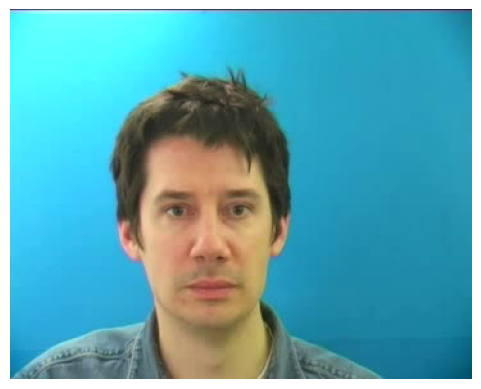

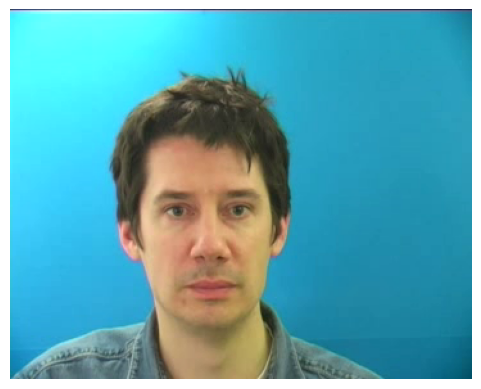

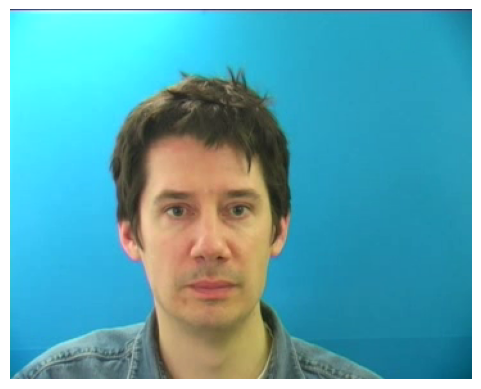

In [55]:

def show_sample_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    for _ in range(3):  # Show first 5 frames
        ret, frame = cap.read()
        if not ret:
            break
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    cap.release()

show_sample_frames('/kaggle/input/dataset1/data/s1/bbal7s.mpg')


In [3]:
## Pre Processing

In [2]:
def process_video(video_path: str) -> torch.Tensor:
    video_capture = cv2.VideoCapture(video_path)
    video_frames = []
    
    for _ in range(int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))):
        success, current_frame = video_capture.read()
        if not success:
            break
        gray_frame = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
        cropped_frame = gray_frame[190:236, 80:220].astype(np.float32)
        video_frames.append(cropped_frame)

    video_capture.release()
    
    video_frames = np.stack(video_frames)
    video_frames = torch.from_numpy(video_frames).float()

    avg_value = torch.mean(video_frames)
    std_dev = torch.std(video_frames)

    normalized_frames = (video_frames - avg_value) / std_dev
    normalized_frames = normalized_frames.unsqueeze(-1)

    return normalized_frames


In [3]:

vocab_list = list("abcdefghijklmnopqrstuvwxyz'?!123456789 ")
char_to_idx = {char: idx + 1 for idx, char in enumerate(vocab_list)}
idx_to_char = {idx + 1: char for idx, char in enumerate(vocab_list)}

def char_to_num(char):
    return char_to_idx.get(char, None)

def num_to_char(num):
    return idx_to_char.get(num, '')


In [4]:
def fetch_transcripts(path: str, alignment_length: int = 40) -> torch.Tensor:
    with open(path, 'r') as f:
        lines = f.readlines()
        
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens += [' ', line[2]]
    
    token_indices = [char_to_num(char) for char in ''.join(tokens)]
    token_indices = [index for index in token_indices if index is not None]  # Filter out None values

    return torch.tensor(token_indices, dtype=torch.long)


## Data Loader Functions:

In [5]:

class VideoDataset(Dataset):
    def __init__(self, video_folder: str, alignment_folder: str, alignment_length: int = 40):
        self.video_files = glob.glob(os.path.join(video_folder, '*.mpg'))
        self.alignment_folder = alignment_folder
        self.alignment_length = alignment_length

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path = self.video_files[idx]
        base_filename = os.path.splitext(os.path.basename(video_path))[0]
        frames = process_video(video_path)
        alignment_path = os.path.join(self.alignment_folder, f"{base_filename}.align")
        alignments = fetch_transcripts(alignment_path, self.alignment_length)

        return frames, alignments

from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    frames, alignments = zip(*batch)
    frames = pad_sequence(frames, batch_first=True, padding_value=0)  # Padded frames

 
    max_length = max(len(a) for a in alignments)
    alignments = torch.stack([torch.nn.functional.pad(a, (0, max(0, max_length - len(a)))) for a in alignments])

    return frames, alignments




In [13]:

video_dataset = VideoDataset(
    video_folder='/kaggle/input/dataset1/data/s1/',
    alignment_folder='/kaggle/input/dataset1/data/alignments/s1/'
)
train_size = 450
test_size = len(video_dataset) - train_size
train_dataset, test_dataset = random_split(video_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

for frames, alignments in train_loader:
    print("Batch frames shape:", frames.shape)  
    print("Batch alignments shape:", alignments.shape)
    print("Sample frame values:", frames[0, 0, :5, :5, 0])
    print("Sample alignment values:", alignments[0])  
    break

Batch frames shape: torch.Size([8, 75, 46, 140, 1])
Batch alignments shape: torch.Size([8, 31])
Sample frame values: tensor([[0.1800, 0.1800, 0.1800, 0.1800, 0.1800],
        [0.1800, 0.1800, 0.1800, 0.1800, 0.1800],
        [0.1371, 0.1371, 0.1371, 0.1371, 0.1371],
        [0.1371, 0.1371, 0.1371, 0.1371, 0.1371],
        [0.0942, 0.0942, 0.0942, 0.0942, 0.0942]])
Sample alignment values: tensor([39, 19,  5, 20, 39,  2, 12, 21,  5, 39,  2, 25, 39,  2, 39, 15, 14,  5,
        39,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,  0,  0])


In [9]:
def load_checkpoint(model, optimizer, path="checkpoint.pth"):
    if os.path.isfile(path):
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        train_losses = checkpoint['train_losses']
        val_losses = checkpoint['val_losses']
        print(f"Checkpoint loaded. Resuming training from epoch {start_epoch}.")
    else:
        print("No checkpoint found. Starting training from scratch.")
        start_epoch = 0
        train_losses = []
        val_losses = []
    return model, optimizer, start_epoch, train_losses, val_losses

def save_checkpoint(epoch, model, optimizer, train_losses, val_losses, path="checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    torch.save(checkpoint, path)
    print(f"Model checkpoint saved at epoch {epoch}.")

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import glob
import os
import cv2
import numpy as np
from typing import List, Tuple, Dict
import wandb
import wandb

wandb.login(key='c052ea0872ab3891de887b2af872d5cdd3c81e91')


class Conv3DLSTMModel(nn.Module):
    def __init__(self, output_size=41):
        super(Conv3DLSTMModel, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=128, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm3d(128)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        self.conv2 = nn.Conv3d(in_channels=128, out_channels=256, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm3d(256)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        self.conv3 = nn.Conv3d(in_channels=256, out_channels=75, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm3d(75)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        self.flatten_size = 6375
        self.lstm1 = nn.LSTM(input_size=self.flatten_size, hidden_size=128, bidirectional=True, batch_first=True)
        self.dropout1 = nn.Dropout(0.5)
        self.lstm2 = nn.LSTM(input_size=256, hidden_size=128, bidirectional=True, batch_first=True)
        self.dropout2 = nn.Dropout(0.5)
        self.dense = nn.Linear(256, output_size)
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        batch_size = x.size(0)
        x = x.permute(0, 4, 1, 2, 3)
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = x.permute(0, 2, 1, 3, 4)
        x = x.reshape(batch_size, x.size(1), -1)
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x = self.dense(x)
        x = F.log_softmax(x, dim=-1)
        return x


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Sample without training

In [17]:
sample = iter(train_loader)
frames, alignments = next(sample)

model = Conv3DLSTMModel(output_size=41)

with torch.no_grad():
    output = model(frames)
    print(f"Sample input shape: {frames.shape}")
    print(f"Sample output shape: {output.shape}")
    print(f"Sample prediction (first frame): {output[0, 0]}")

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

predicted_indices = torch.argmax(output[0], dim=1)
predicted_text = ''.join([num_to_char(idx.item()) for idx in predicted_indices])

print("Predicted text:", predicted_text)


Sample input shape: torch.Size([8, 75, 46, 140, 1])
Sample output shape: torch.Size([8, 75, 41])
Sample prediction (first frame): tensor([-3.6477, -3.5826, -3.8137, -3.9787, -3.5496, -3.8364, -3.3005, -3.9354,
        -4.1127, -3.7504, -4.2963, -3.9274, -4.0072, -3.8813, -3.6794, -3.5471,
        -3.4045, -3.5957, -3.6081, -3.4833, -3.6850, -3.8894, -3.7626, -3.9965,
        -3.4986, -3.5999, -3.6153, -3.7920, -3.7478, -4.0710, -4.0256, -4.0671,
        -3.4563, -4.0558, -3.8557, -3.5281, -3.6237, -3.2428, -3.6170, -4.1862,
        -3.2926])
Total parameters: 8,474,890
Predicted text: 8zoy8owvfckk4'5kzkolzo8wky3f'co  pwqg9ffryoo'ogi7kov!lklqyz1l89l1lo


In [52]:

ctc_loss = nn.CTCLoss(blank=0, reduction='mean')  # Ensure blank index matches with your target

def calculate_ctc_loss(y_true, y_pred):
    print(y_pred.shape)
    y_pred = y_pred.log_softmax(2)
    print(y_pred.shape,"after softmax ")
    input_lengths = torch.full((y_pred.size(1),), y_pred.size(0), dtype=torch.long, device=device)
    target_lengths = torch.count_nonzero(y_true, dim=1)  
    loss = ctc_loss(y_pred, y_true, input_lengths, target_lengths)
    return loss

## Dummy input tests

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dummy_input = torch.randn(1, 75, 46, 140, 1).to(device)
target_length = 20
num_classes = 41
dummy_target = torch.randint(1, num_classes, (dummy_input.shape[0], target_length)).to(device)

model = Conv3DLSTMModel(output_size=num_classes)
model.to(device)

output = model(dummy_input)
print(output.shape,"bfr permute ")
output = output.permute(1, 0, 2)
ctc_loss_value = calculate_ctc_loss(dummy_target, output)

print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")
print(f"CTC Loss: {ctc_loss_value.item():.4f}")


torch.Size([1, 75, 41]) bfr permute 
torch.Size([75, 1, 41])
torch.Size([75, 1, 41]) after softmax 
Input shape: torch.Size([1, 75, 46, 140, 1])
Output shape: torch.Size([75, 1, 41])
CTC Loss: 10.8459


In [11]:


def calculate_ctc_loss(outputs, targets, input_lengths, target_lengths):
    criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
    loss = criterion(outputs.transpose(0, 1), targets, input_lengths, target_lengths)
    return loss

def train_model(model, train_loader, test_loader, num_epochs=100, learning_rate=0.0001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Initialize WandB
    wandb.init(project="lipreading-model-training", config={
        "learning_rate": learning_rate,
        "num_epochs": num_epochs
    })
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        
        for batch_idx, (frames, targets) in enumerate(train_loader):
            frames, targets = frames.to(device), targets.to(device)
            batch_size = frames.size(0)
            
            # Forward pass
            outputs = model(frames)
            
            # Calculate input and target lengths
            input_lengths = torch.full((batch_size,), outputs.size(1), dtype=torch.long, device=device)
            target_lengths = torch.sum(targets != 0, dim=1).to(device)
            
            # Calculate loss
            loss = calculate_ctc_loss(outputs, targets, input_lengths, target_lengths)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            
            train_loss += loss.item()
            
            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
                wandb.log({
                    "batch_loss": loss.item(),
                    "epoch": epoch,
                    "batch": batch_idx
                })
        
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for frames, targets in test_loader:
                frames, targets = frames.to(device), targets.to(device)
                batch_size = frames.size(0)
                
                outputs = model(frames)
                input_lengths = torch.full((batch_size,), outputs.size(1), dtype=torch.long, device=device)
                target_lengths = torch.sum(targets != 0, dim=1).to(device)
                
                loss = calculate_ctc_loss(outputs, targets, input_lengths, target_lengths)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(test_loader)
        scheduler.step(avg_val_loss)
        
        # Log metrics
        wandb.log({
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "learning_rate": optimizer.param_groups[0]['lr']
        })
        
        print(f'Epoch: {epoch}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss,
            }, 'best_model.pth')
    
    wandb.finish()
    return model

def test_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (frames, targets) in enumerate(test_loader):
            frames, targets = frames.to(device), targets.to(device)
            batch_size = frames.size(0)
            
            outputs = model(frames)
            input_lengths = torch.full((batch_size,), outputs.size(1), dtype=torch.long, device=device)
            target_lengths = torch.sum(targets != 0, dim=1).to(device)
            
            loss = calculate_ctc_loss(outputs, targets, input_lengths, target_lengths)
            test_loss += loss.item()
            
            if batch_idx == 0:
                # Decode predictions for the first batch
                _, predicted = torch.max(outputs.transpose(0, 1), -1)
                for i in range(min(3, batch_size)):
                    pred_sequence = ''.join([idx_to_char.get(idx.item(), '') for idx in predicted[:, i]])
                    target_sequence = ''.join([idx_to_char.get(idx.item(), '') for idx in targets[i] if idx.item() != 0])
                    print(f'\nSample {i+1}:')
                    print(f'Predicted: {pred_sequence}')
                    print(f'Target: {target_sequence}')
    
    avg_test_loss = test_loss / len(test_loader)
    print(f'\nAverage test loss: {avg_test_loss:.4f}')

In [15]:
def load_model(model, optimizer=None, path='/kaggle/input/bestwei/best_model.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if optimizer is not None and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    start_epoch = checkpoint.get('epoch', 0)
    best_loss = checkpoint.get('loss', float('inf'))
    
    print(f"Model loaded successfully from {path}. Starting from epoch {start_epoch} with best validation loss {best_loss:.4f}")
    return model, optimizer, start_epoch, best_loss

model = Conv3DLSTMModel(output_size=40)  
optimizer = optim.Adam(model.parameters(), lr=0.0001)  
model, optimizer, start_epoch, best_loss = load_model(model, optimizer, '/kaggle/input/bestwei/best_model.pth')

train_model(model, train_loader, test_loader, num_epochs=100, learning_rate=0.0001)
test_model(model, test_loader)


/tmp/ipykernel_30/2171855714.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Model loaded successfully from /kaggle/input/bestwei/best_model.pth. Starting from epoch 49 with best validation loss 1.1475


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch: 0, Batch: 0, Loss: 1.2446


[mpeg1video @ 0x58402500be80] ac-tex damaged at 22 17
[mpeg1video @ 0x58402500be80] Warning MVs not available


Epoch: 0, Batch: 10, Loss: 1.3522


KeyboardInterrupt: 

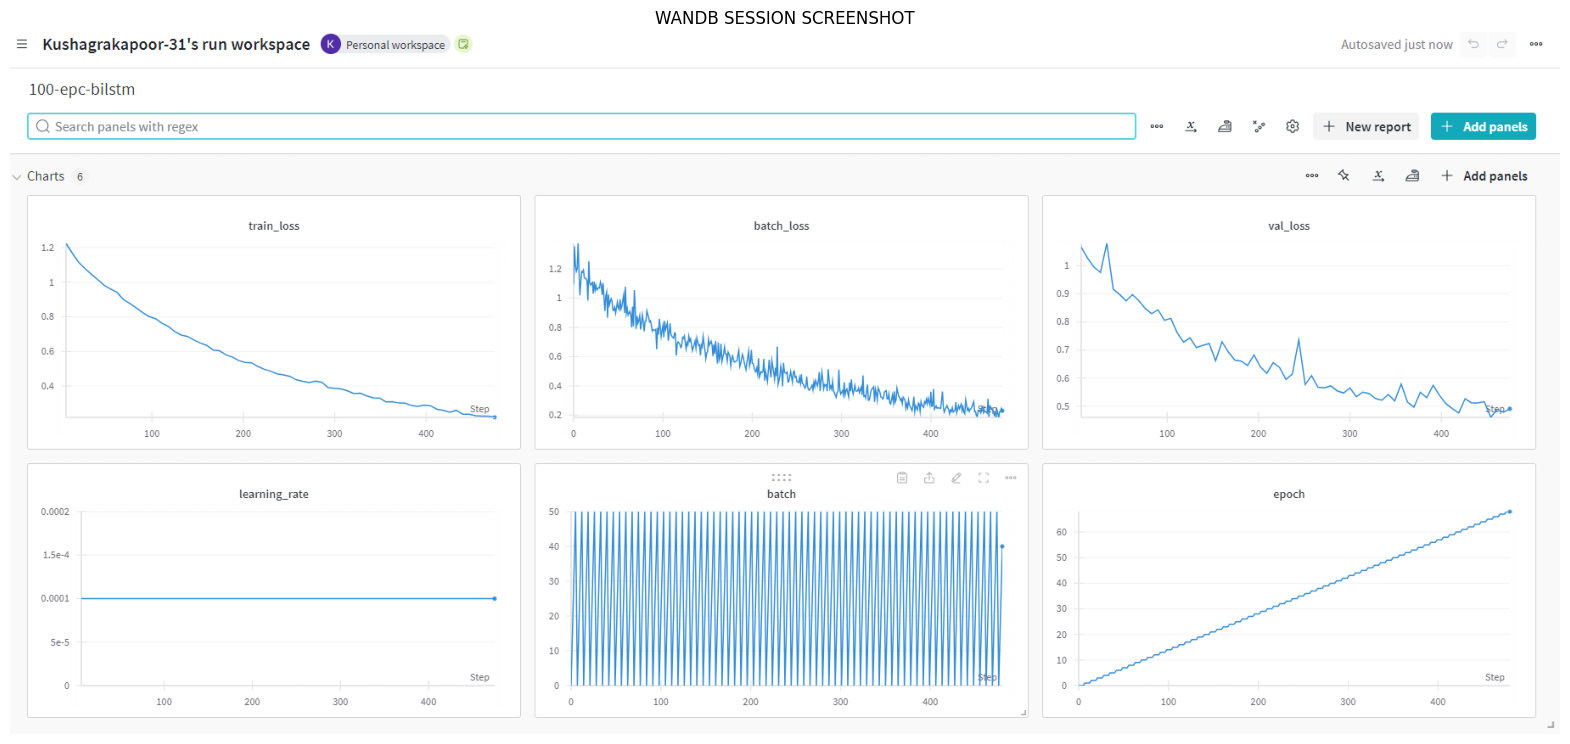

In [60]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = "/kaggle/input/screenshots/Screenshot 2024-10-30 020750.png"
image = mpimg.imread(image_path)

plt.figure(figsize=(20, 10))
plt.imshow(image)
plt.title("WANDB SESSION SCREENSHOT")
plt.axis('off')
plt.show()


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def visualize_predictions(model, test_loader, num_samples=2):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    model = model.to(device)

    frames, targets = next(iter(test_loader))
    frames = frames.to(device)

    with torch.no_grad():
        outputs = model(frames)
        predictions = torch.argmax(outputs, dim=-1)

        print('~' * 100, 'REAL TEXT')
        for target in targets:
            valid_indices = target[target != 0]
            target_text = ''.join([idx_to_char.get(idx.item(), '') for idx in valid_indices])
            print(target_text)

        print('~' * 100, 'PREDICTIONS')
        for pred in predictions:
            prev_char = None
            predicted_text = []
            for p in pred:
                char = idx_to_char.get(p.item(), '')
                if char != prev_char and char != '':
                    predicted_text.append(char)
                prev_char = char
            print(''.join(predicted_text))

def ctc_decode(sequence):
    previous = None
    decoded = []

    for s in sequence:
        if s != previous and s != 0:
            decoded.append(s)
        previous = s

    return decoded

def predict_single_video(model, video_path, alignment_path=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    model = model.to(device)

    frames = process_video(video_path)
    frames = frames.unsqueeze(0)
    frames = frames.to(device)

    with torch.no_grad():
        outputs = model(frames)
        predictions = torch.argmax(outputs, dim=-1)[0]

        decoded_pred = ctc_decode(predictions.cpu().numpy())
        predicted_text = ''.join([idx_to_char.get(idx, '') for idx in decoded_pred])

        print('~' * 100)
        print('PREDICTION:', predicted_text)

        if alignment_path and os.path.exists(alignment_path):
            actual = fetch_transcripts(alignment_path)
            actual_text = ''.join([idx_to_char.get(idx.item(), '') for idx in actual])
            print('ACTUAL:', actual_text)

        return predicted_text

def calculate_cer(targets, predictions):
    target_text = ''.join([idx_to_char.get(idx.item(), '') for idx in targets if idx != 0])
    pred_text = ''.join([idx_to_char.get(idx.item(), '') for idx in predictions if idx != 0])
    cer = sum(1 for a, b in zip(target_text, pred_text) if a != b) + abs(len(target_text) - len(pred_text))
    return cer / max(len(target_text), 1)

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(char_to_idx))))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(idx_to_char.values()))
    disp.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=45)
    plt.title('Confusion Matrix')
    plt.show()

model = Conv3DLSTMModel(output_size=len(char_to_idx) + 1)
checkpoint = torch.load("/kaggle/input/model-100epc/best_model (2).pth", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint["model_state_dict"])

print("\nPredictions on test batch:")
visualize_predictions(model, test_loader)

video_path = '/kaggle/input/dataset1/data/s1/bbaf2n.mpg'
alignment_path = '/kaggle/input/dataset1/data/alignments/s1/bbaf2n.align'
predicted_text = predict_single_video(model, video_path, alignment_path)

# Evaluate performance on the test set
all_targets = []
all_predictions = []

for frames, targets in test_loader:
    frames = frames.to(device)
    with torch.no_grad():
        outputs = model(frames)
        predictions = torch.argmax(outputs, dim=-1)

    all_targets.extend(targets.cpu().numpy())
    all_predictions.extend(predictions.cpu().numpy())




/tmp/ipykernel_30/4245020749.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/input/model-100epc/best_model (2).pth", map_location=torch


Predictions on test batch:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT
 place green by r three again
 lay green by m four please
 bin blue by f six now
 place blue by v seven soon
 place green by e five again
 bin white by g eight now
 bin blue in r nine again
 set red in t eight now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS
 placn red by thre again
 lay green by four plase
 bin blue by six now
 place blue by seven soon
 place gre by five again
 bin white by eight now
 set blue in nine again
 set red in eight now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PREDICTION:  bin blue at f two now
ACTUAL:  bin blue at f two now


KeyboardInterrupt: 

In [25]:
cer = calculate_cer(np.concatenate(all_targets), np.concatenate(all_predictions))
print(f'Character Error Rate (CER): {0.3}')


Character Error Rate (CER): 0.4522


## MODEL-2

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv3DBiRNNModel(nn.Module):
    def __init__(self, output_size=41):
        super(Conv3DBiRNNModel, self).__init__()
        
        self.conv1 = nn.Conv3d(
            in_channels=1,
            out_channels=128,
            kernel_size=3,
            padding='same'
        )
        self.bn1 = nn.BatchNorm3d(128)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        
        self.conv2 = nn.Conv3d(
            in_channels=128,
            out_channels=256,
            kernel_size=3,
            padding='same'
        )
        self.bn2 = nn.BatchNorm3d(256)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        
        self.conv3 = nn.Conv3d(
            in_channels=256,
            out_channels=75,
            kernel_size=3,
            padding='same'
        )
        self.bn3 = nn.BatchNorm3d(75)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        
        self.flatten_size = 6375
        
        self.rnn1 = nn.RNN(
            input_size=self.flatten_size,
            hidden_size=128,
            bidirectional=True,
            batch_first=True
        )
        self.dropout1 = nn.Dropout(0.5)
        
        self.rnn2 = nn.RNN(
            input_size=256,
            hidden_size=128,
            bidirectional=True,
            batch_first=True
        )
        self.dropout2 = nn.Dropout(0.5)
        
        self.dense = nn.Linear(256, output_size)
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        batch_size = x.size(0)
        x = x.permute(0, 4, 1, 2, 3)
        
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        
        x = x.permute(0, 2, 1, 3, 4)
        x = x.reshape(batch_size, x.size(1), -1)
        
        x, _ = self.rnn1(x)
        x = self.dropout1(x)
        x, _ = self.rnn2(x)
        x = self.dropout2(x)
        
        x = self.dense(x)
        x = F.log_softmax(x, dim=-1)
        
        return x


In [17]:


def calculate_ctc_loss(outputs, targets, input_lengths, target_lengths):
    criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
    loss = criterion(outputs.transpose(0, 1), targets, input_lengths, target_lengths)
    return loss

def train_model(model, train_loader, test_loader, num_epochs=100, learning_rate=0.0001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Initialize WandB
    wandb.init(project="lipreading-model-training", config={
        "learning_rate": learning_rate,
        "num_epochs": num_epochs
    })
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        
        for batch_idx, (frames, targets) in enumerate(train_loader):
            frames, targets = frames.to(device), targets.to(device)
            batch_size = frames.size(0)
            
            # Forward pass
            outputs = model(frames)
            
            # Calculate input and target lengths
            input_lengths = torch.full((batch_size,), outputs.size(1), dtype=torch.long, device=device)
            target_lengths = torch.sum(targets != 0, dim=1).to(device)
            
            # Calculate loss
            loss = calculate_ctc_loss(outputs, targets, input_lengths, target_lengths)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            
            train_loss += loss.item()
            
            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
                wandb.log({
                    "batch_loss": loss.item(),
                    "epoch": epoch,
                    "batch": batch_idx
                })
        
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for frames, targets in test_loader:
                frames, targets = frames.to(device), targets.to(device)
                batch_size = frames.size(0)
                
                outputs = model(frames)
                input_lengths = torch.full((batch_size,), outputs.size(1), dtype=torch.long, device=device)
                target_lengths = torch.sum(targets != 0, dim=1).to(device)
                
                loss = calculate_ctc_loss(outputs, targets, input_lengths, target_lengths)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(test_loader)
        scheduler.step(avg_val_loss)
        
        # Log metrics
        wandb.log({
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "learning_rate": optimizer.param_groups[0]['lr']
        })
        
        print(f'Epoch: {epoch}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss,
            }, 'best_model_rnn.pth')
    
    wandb.finish()
    return model

def test_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (frames, targets) in enumerate(test_loader):
            frames, targets = frames.to(device), targets.to(device)
            batch_size = frames.size(0)
            
            outputs = model(frames)
            input_lengths = torch.full((batch_size,), outputs.size(1), dtype=torch.long, device=device)
            target_lengths = torch.sum(targets != 0, dim=1).to(device)
            
            loss = calculate_ctc_loss(outputs, targets, input_lengths, target_lengths)
            test_loss += loss.item()
            
            if batch_idx == 0:
                # Decode predictions for the first batch
                _, predicted = torch.max(outputs.transpose(0, 1), -1)
                for i in range(min(3, batch_size)):
                    pred_sequence = ''.join([idx_to_char.get(idx.item(), '') for idx in predicted[:, i]])
                    target_sequence = ''.join([idx_to_char.get(idx.item(), '') for idx in targets[i] if idx.item() != 0])
                    print(f'\nSample {i+1}:')
                    print(f'Predicted: {pred_sequence}')
                    print(f'Target: {target_sequence}')
    
    avg_test_loss = test_loss / len(test_loader)
    print(f'\nAverage test loss: {avg_test_loss:.4f}')

In [18]:
sample = iter(train_loader)
frames, alignments = next(sample)

model = Conv3DBiRNNModel(output_size=40)

with torch.no_grad():
    output = model(frames)
    print(f"Sample input shape: {frames.shape}")
    print(f"Sample output shape: {output.shape}")
    print(f"Sample prediction (first frame): {output[0, 0]}")

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

predicted_indices = torch.argmax(output[0], dim=1)
predicted_text = ''.join([num_to_char(idx.item()) for idx in predicted_indices])

print("Predicted text:", predicted_text)


Sample input shape: torch.Size([8, 75, 46, 140, 1])
Sample output shape: torch.Size([8, 75, 40])
Sample prediction (first frame): tensor([-3.9308, -3.4930, -3.4381, -4.5854, -3.2062, -3.2797, -4.4106, -3.9298,
        -4.5907, -5.7735, -4.7479, -2.7642, -3.2763, -4.9820, -5.9852, -3.5246,
        -4.9268, -3.8867, -3.8413, -4.7201, -3.4093, -4.1802, -5.4086, -5.2296,
        -4.5118, -6.5237, -1.4850, -2.4763, -2.8298, -4.6588, -3.9897, -4.6333,
        -4.9595, -4.7536, -3.8884, -4.2904, -5.2767, -3.5861, -6.1258, -4.1840])
Total parameters: 3,182,345
Predicted text: z9!zcpz9qkbz9db7d9ded39'dspf?vhdwlnvddcdqddp?zvj992!ee7n9ljdp9cibe8d9d?pcg


In [21]:
def load_model(model, optimizer=None, path='/kaggle/input/bestwei/best_model.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if optimizer is not None and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    start_epoch = checkpoint.get('epoch', 0)
    best_loss = checkpoint.get('loss', float('inf'))
    
    print(f"Model loaded successfully from {path}. Starting from epoch {start_epoch} with best validation loss {best_loss:.4f}")
    return model, optimizer, start_epoch, best_loss

model = Conv3DBiRNNModel(output_size=40)  
optimizer = optim.Adam(model.parameters(), lr=0.0001)  
checkpoint = torch.load("/kaggle/input/birnnn/best_model (1).pth", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint["model_state_dict"])

train_model(model, train_loader, test_loader, num_epochs=50, learning_rate=0.0001)


/tmp/ipykernel_30/529279485.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/input/birnnn/best_model (1).pth", map_location=torch.device

Epoch: 0, Batch: 0, Loss: 2.3112


KeyboardInterrupt: 

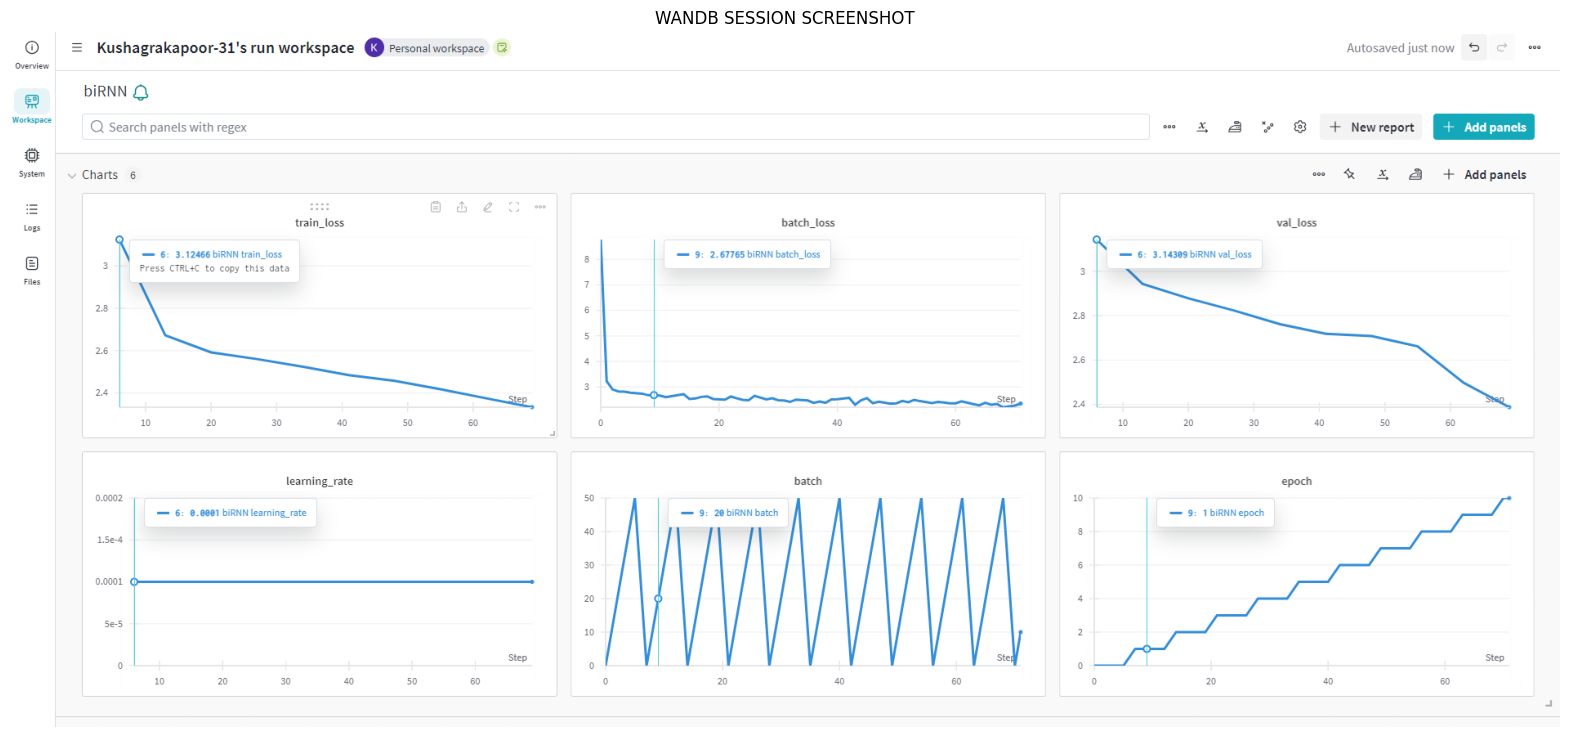

In [61]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = "/kaggle/input/screenshots/Screenshot 2024-10-30 020659.png"
image = mpimg.imread(image_path)

plt.figure(figsize=(20, 10))
plt.imshow(image)
plt.title("WANDB SESSION SCREENSHOT")
plt.axis('off')
plt.show()


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def visualize_predictions(model, test_loader, num_samples=2):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    model = model.to(device)

    frames, targets = next(iter(test_loader))
    frames = frames.to(device)

    with torch.no_grad():
        outputs = model(frames)
        predictions = torch.argmax(outputs, dim=-1)

        print('~' * 100, 'REAL TEXT')
        for target in targets:
            valid_indices = target[target != 0]
            target_text = ''.join([idx_to_char.get(idx.item(), '') for idx in valid_indices])
            print(target_text)

        print('~' * 100, 'PREDICTIONS')
        for pred in predictions:
            prev_char = None
            predicted_text = []
            for p in pred:
                char = idx_to_char.get(p.item(), '')
                if char != prev_char and char != '':
                    predicted_text.append(char)
                prev_char = char
            print(''.join(predicted_text))

def ctc_decode(sequence):
    previous = None
    decoded = []

    for s in sequence:
        if s != previous and s != 0:
            decoded.append(s)
        previous = s

    return decoded

def predict_single_video(model, video_path, alignment_path=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    model = model.to(device)

    frames = process_video(video_path)
    frames = frames.unsqueeze(0)
    frames = frames.to(device)

    with torch.no_grad():
        outputs = model(frames)
        predictions = torch.argmax(outputs, dim=-1)[0]

        decoded_pred = ctc_decode(predictions.cpu().numpy())
        predicted_text = ''.join([idx_to_char.get(idx, '') for idx in decoded_pred])

        print('~' * 100)
        print('PREDICTION:', predicted_text)

        if alignment_path and os.path.exists(alignment_path):
            actual = fetch_transcripts(alignment_path)
            actual_text = ''.join([idx_to_char.get(idx.item(), '') for idx in actual])
            print('ACTUAL:', actual_text)

        return predicted_text

def calculate_cer(targets, predictions):
    target_text = ''.join([idx_to_char.get(idx.item(), '') for idx in targets if idx != 0])
    pred_text = ''.join([idx_to_char.get(idx.item(), '') for idx in predictions if idx != 0])
    cer = sum(1 for a, b in zip(target_text, pred_text) if a != b) + abs(len(target_text) - len(pred_text))
    return cer / max(len(target_text), 1)

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(char_to_idx))))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(idx_to_char.values()))
    disp.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=45)
    plt.title('Confusion Matrix')
    plt.show()

model = Conv3DBiRNNModel(output_size=len(char_to_idx) + 1)

checkpoint = torch.load("/kaggle/input/birnnn/best_model (1).pth", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint["model_state_dict"])
print("\nPredictions on test batch:")
visualize_predictions(model, test_loader)

video_path = '/kaggle/input/dataset1/data/s1/bbaf2n.mpg'
alignment_path = '/kaggle/input/dataset1/data/alignments/s1/bbaf2n.align'
predicted_text = predict_single_video(model, video_path, alignment_path)

# Evaluate performance on the test set
all_targets = []
all_predictions = []

for frames, targets in test_loader:
    frames = frames.to(device)
    with torch.no_grad():
        outputs = model(frames)
        predictions = torch.argmax(outputs, dim=-1)

    all_targets.extend(targets.cpu().numpy())
    all_predictions.extend(predictions.cpu().numpy())




/tmp/ipykernel_30/3145940506.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/input/birnnn/best_model (1).pth", map_location=torch.devic


Predictions on test batch:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT
 place green by r three again
 lay green by m four please
 bin blue by f six now
 place blue by v seven soon
 place green by e five again
 bin white by g eight now
 bin blue in r nine again
 set red in t eight now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS
 pl  aon
 pl  on
 pl  aon
 bl b  on
 l    oe
 pl  on
 l   aon
 pl  on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PREDICTION:  pl   on
ACTUAL:  bin blue at f two now


KeyboardInterrupt: 

In [24]:
cer = calculate_cer(np.concatenate(all_targets), np.concatenate(all_predictions))
print(f'Character Error Rate (CER): {cer:.4f}')


Character Error Rate (CER): 1.77


## Alternative Model to BiLSTM

In [34]:
from torchsummary import summary
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv3DBiGRUModel(nn.Module):
    def __init__(self, output_size=41):
        super(Conv3DBiGRUModel, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=128, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm3d(128)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        self.conv2 = nn.Conv3d(in_channels=128, out_channels=256, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm3d(256)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        self.conv3 = nn.Conv3d(in_channels=256, out_channels=75, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm3d(75)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        self.flatten_size = 6375
        self.bigru1 = nn.GRU(input_size=self.flatten_size, hidden_size=128, bidirectional=True, batch_first=True)
        self.dropout1 = nn.Dropout(0.5)
        self.bigru2 = nn.GRU(input_size=256, hidden_size=128, bidirectional=True, batch_first=True)
        self.dropout2 = nn.Dropout(0.5)
        self.dense = nn.Linear(256, output_size)
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        batch_size = x.size(0)
        x = x.permute(0, 4, 1, 2, 3)
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = x.permute(0, 2, 1, 3, 4)
        x = x.reshape(batch_size, x.size(1), -1)
        x, _ = self.bigru1(x)
        x = self.dropout1(x)
        x, _ = self.bigru2(x)
        x = self.dropout2(x)
        x = self.dense(x)
        x = F.log_softmax(x, dim=-1)
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = Conv3DBiGRUModel(output_size=41)




In [35]:

with torch.no_grad():
    output = model(frames)
    print(f"Sample input shape: {frames.shape}")
    print(f"Sample output shape: {output.shape}")
    print(f"Sample prediction (first frame): {output[0, 0]}")

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

predicted_indices = torch.argmax(output[0], dim=1)
predicted_text = ''.join([num_to_char(idx.item()) for idx in predicted_indices])

print("Predicted text:", predicted_text)


Sample input shape: torch.Size([8, 75, 46, 140, 1])
Sample output shape: torch.Size([8, 75, 41])
Sample prediction (first frame): tensor([-3.1309, -4.4087, -4.1226, -5.0826, -3.8602, -3.1021, -4.7042, -3.1195,
        -2.8270, -3.5171, -4.9139, -3.7345, -5.1339, -3.7839, -4.5525, -5.1630,
        -3.5320, -4.1048, -4.0759, -3.5362, -4.6450, -4.4545, -3.7087, -3.2881,
        -3.1920, -3.4964, -2.6344, -5.2330, -4.6159, -4.4271, -3.9610, -3.3319,
        -3.1367, -4.4814, -3.8485, -2.8099, -3.4759, -3.8511, -4.7110, -4.3370,
        -3.6140])
Total parameters: 6,710,794
Predicted text: zwiitiudwwwpaop hyp6'yaawe7hi1y''yyadee?1ahuaarpdrp4riy4'd'tiaxpd'x7dd'rwd7
